In [266]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from collections import defaultdict as d
import sklearn
from sklearn.cross_validation import train_test_split as tts
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-pastel')
%matplotlib inline

In [267]:
cnames=['prov ID','province','dept ID','dept','cult ID','cult','year ID','year','sown area','harvested area','product','productivity']
df=pd.read_csv('estimaciones.csv',sep=';',skiprows=2,header=None,names=cnames)

/Users/dyanni3/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# exploration/cleaning:

First off, just going to have a look at how the productivity of the different agricultural centers is distributed

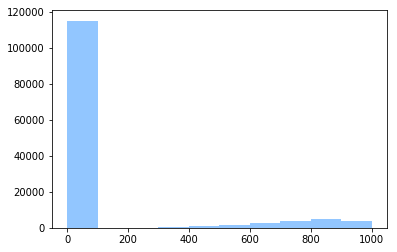

In [268]:
_=plt.hist(df['productivity'])

If you go investigate these really large values, it becomes clear that they are just data entry mistakes

In [269]:
df[df['productivity']>200].head()

,prov ID,province,dept ID,dept,cult ID,cult,year ID,year,sown area,harvested area,product,productivity
633,10,CATAMARCA,7,AMBATO,1,Ajo,3,1971/72,6.0,6.0,4,667.0
659,10,CATAMARCA,14,ANCASTI,1,Ajo,2,1970/71,5.0,2.0,1,500.0
660,10,CATAMARCA,14,ANCASTI,1,Ajo,3,1971/72,5.0,5.0,2,400.0
662,10,CATAMARCA,21,ANDALGALA,1,Ajo,2,1970/71,8.0,6.0,5,833.0
663,10,CATAMARCA,21,ANDALGALA,1,Ajo,3,1971/72,10.0,10.0,6,600.0


productivity should be defined as $\frac{\text{product}}{\text{harvested area}}$, which in the case of index $633$ ought to be $0.667$ but somehow is $1000$ times too large. In general this is true for all of the high productivity values. We can just clean this up:

In [270]:
df['product']=pd.to_numeric(df['product'],'coerce')
df['productivity']=(df['product']/df['harvested area'])
df=df.replace([np.inf, -np.inf], np.nan).fillna(0)
df.productivity[df.productivity>200]=df.productivity[df.productivity>200].divide(1000)

/Users/dyanni3/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Now our histogram of productivity looks a lot more sensible.

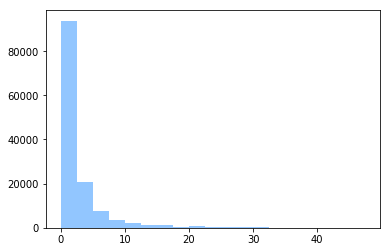

In [271]:
v=plt.hist(df['productivity'],bins=[2.5*i for i in range(20)])


Next just get a sense of the correlation between our numeric values

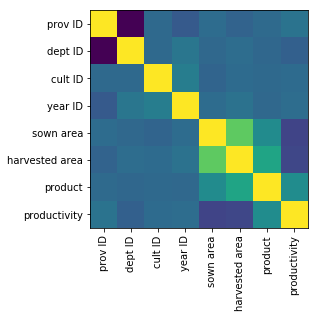

In [272]:
df['product']=pd.to_numeric(df['product'],'coerce')
df_numeric=df._get_numeric_data()
c=df_numeric.corr()
plt.imshow(c)
plt.xticks(np.arange(8),df_numeric.columns,rotation='vertical');
plt.yticks(np.arange(8),df_numeric.columns);

In [273]:
c['productivity']

prov ID           0.064988
dept ID          -0.049239
cult ID           0.017257
year ID           0.028073
sown area        -0.198877
harvested area   -0.187954
product           0.224351
productivity      1.000000
Name: productivity, dtype: float64

Now let's see where is the most productive province!

In [274]:
provinces=np.unique(df['prov ID'])
prov_prod=np.zeros(provinces.size)
err=np.zeros(provinces.size)
for i,prov in enumerate(provinces):
    prov_prod[i]=np.average(df[df['prov ID']==prov]['productivity'])
    err[i]=np.std(df[df['prov ID']==prov]['productivity'])
sorted_prov=provinces[np.argsort(prov_prod)]
prov_names=[np.unique(df[df['prov ID']==provinces[i]]['province'])[0] for i in range(provinces.size)]
prov_names=np.array(prov_names)

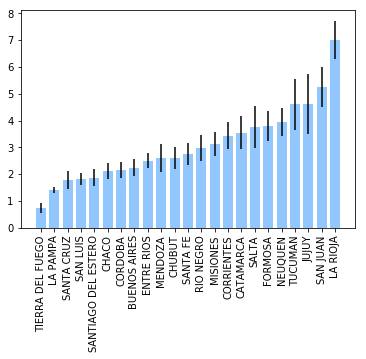

In [275]:
plt.bar(provinces,np.sort(prov_prod),3,yerr=err[np.argsort(prov_prod)]*.1)
plt.xticks(provinces,prov_names[np.argsort(prov_prod)],rotation='vertical');

Now we can remake our covariance matrix with the new (sorted) province IDs

In [276]:
new_prov_id_dict=d(list)
for i,name in enumerate(prov_names[np.argsort(prov_prod)]):
    new_prov_id_dict[name]=i*1.0
dat=[new_prov_id_dict[i] for i in df['province']]
for i,thing in enumerate(dat):
    if thing==[]:
        #print('found')
        dat[i]=None
df['new prov ID'] = pd.Series(dat, index=df.index)
df['new prov ID']=pd.to_numeric(df['new prov ID'],errors='coerce')

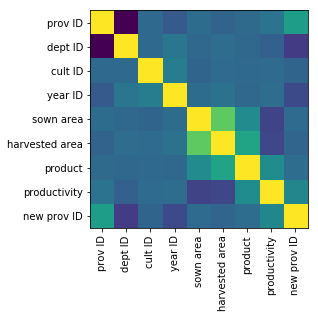

In [277]:
df_numeric=df._get_numeric_data()
c2=df_numeric.corr()
plt.imshow(c2)
plt.xticks(np.arange(9),df_numeric.columns,rotation='vertical');
plt.yticks(np.arange(9),df_numeric.columns);

In [278]:
c2['productivity']

prov ID           0.064988
dept ID          -0.049239
cult ID           0.017257
year ID           0.028073
sown area        -0.198877
harvested area   -0.187954
product           0.224351
productivity      1.000000
new prov ID       0.181507
Name: productivity, dtype: float64

We can do the same sort of thing to look at how different departments compare

In [279]:
new_dept_id_dict=d(list)
for i,name in enumerate(pd.unique(df['dept'])):
    new_dept_id_dict[name]=i
df['dept ID']=[new_dept_id_dict[i] for i in df['dept']]
df['dept ID']=pd.to_numeric(df['dept ID'],'coerce')


depts=np.unique(df['dept ID'])
dept_prod=np.zeros(depts.size)
err2=np.zeros(depts.size)
for i,dept in enumerate(depts):
    dept_prod[i]=np.average(df[df['dept ID']==dept]['productivity'])
    err2[i]=np.std(df[df['dept ID']==dept]['productivity'])
sorted_dept=depts[np.argsort(dept_prod)]
dept_names=[np.unique(df[df['dept ID']==depts[i]]['dept']) for i in range(depts.size)]
dept_names=np.array(dept_names)

<Container object of 416 artists>

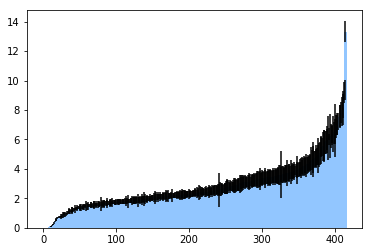

In [280]:
plt.bar(depts,np.sort(dept_prod),3,yerr=err2[np.argsort(dept_prod)]*.1)
#plt.xticks(np.arange(417),np.arange(417));

In [281]:
new_dept_id_dict=d(list)
for i,name in enumerate(dept_names[np.argsort(dept_prod)]):
    new_dept_id_dict[name[0]]=i*1.0
dat=[new_dept_id_dict[i] for i in df['dept']]
for i,thing in enumerate(dat):
    if thing==[]:
        #print('found')
        dat[i]=None
df['new dept ID'] = pd.Series(dat, index=df.index)
df['new dept ID']=pd.to_numeric(df['new dept ID'],errors='coerce')

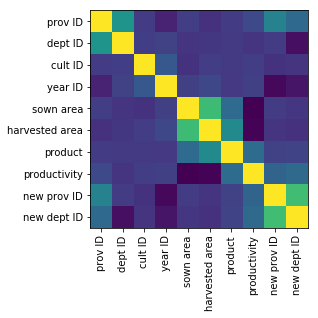

In [282]:
df_numeric=df._get_numeric_data()
c3=df_numeric.corr()
plt.imshow(c3)
plt.xticks(np.arange(10),df_numeric.columns,rotation='vertical');
plt.yticks(np.arange(10),df_numeric.columns);

In [283]:
c3['productivity']


prov ID           0.064988
dept ID          -0.015590
cult ID           0.017257
year ID           0.028073
sown area        -0.198877
harvested area   -0.187954
product           0.224351
productivity      1.000000
new prov ID       0.181507
new dept ID       0.216706
Name: productivity, dtype: float64

# Train a linear regression

Now ready to train a linear regression and try to predict how productive a farm will be.

First going to drop all of the 'ID' features for our categorical variables since we'll be using dummy encoding to model their influence anyway. Then do a train/test split and keep 85% of the data as training data. 

In [284]:
from sklearn.linear_model import LinearRegression as sLR

In [285]:
df=df.drop(labels=['prov ID','dept ID','cult ID','year ID'],axis='columns')
needs_dummies=['province','dept','cult','year']
df_with_dummies = pd.get_dummies(df, columns = needs_dummies )

In [286]:
df_with_dummies.dtypes
train,test=tts(df_with_dummies,test_size=.15)

Now actually train the models

In [287]:
train=train.dropna()
X=train.loc[:,train.columns!='productivity'].values
y=train['productivity'].values
model2=sLR(fit_intercept=True)
model2.fit(X,y)
model3=sLR(fit_intercept=False)
model3.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

How do the models do on training data?

In [288]:
y_train2=model2.predict(X)
y_train3=model3.predict(X)

(0, 40)

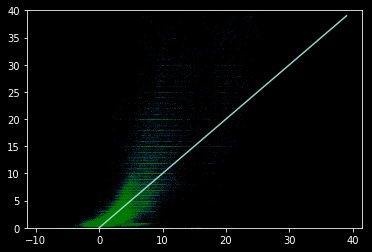

In [319]:
plt.plot(y_train3,y,'b.',ms=.1)
plt.plot(y_train2,y,'g.',ms=.1)
plt.plot(np.arange(40),np.arange(40))
plt.ylim(0,40)

## performance

Now going to make actual predictions on the test data and plot the results

In [320]:
test=test.dropna()
Xtest=test.loc[:,test.columns!='productivity'].values
ytest=test['productivity'].values
y_pred2=model2.predict(Xtest)
y_pred3=model3.predict(Xtest)
y_pred3[y_pred3>250]=0
y_pred2[y_pred2>250]=0

In [321]:
from sklearn.metrics import r2_score
print(r2_score(ytest,y_pred2))
print(r2_score(ytest,y_pred3))

-860034690738.0
0.474380525385


(0, 80)

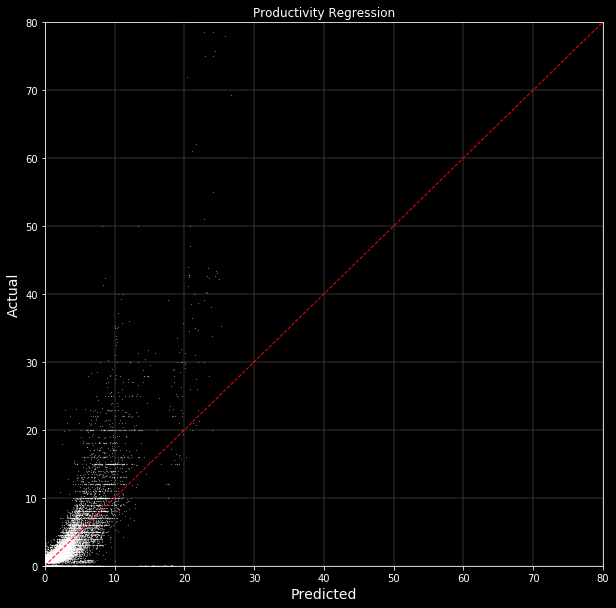

In [322]:
plt.style.use('dark_background')
plt.figure(figsize=(10,10))
plt.plot(y_pred3,ytest,'w.',ms=.3)
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'r--', lw=1)
plt.xlabel("Predicted",fontsize=14)
plt.ylabel("Actual",fontsize=14)
plt.title("Productivity Regression")
plt.grid(c='gray',lw=.4)
plt.xlim(0,80)
plt.ylim(0,80)

In [323]:
thetas=model3.coef_

In [324]:
feature_groups=['provinces','departments','cults','years','sown area','harvested area','product','new prov ID','new dept ID']
theta_vals=[np.sum(thetas[6:30]),np.sum(thetas[31:416]),np.sum(thetas[447:447+33]),np.sum(thetas[447+33:]),thetas[0],thetas[1],thetas[2],thetas[4],thetas[5]]

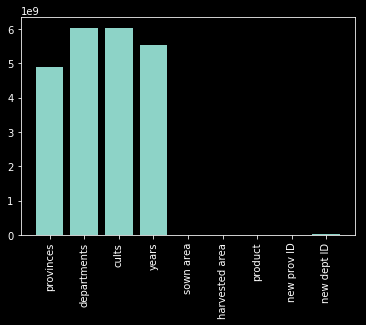

In [325]:
plt.bar(np.arange(len(theta_vals)),[abs(i) for i in theta_vals])
plt.xticks(np.arange(len(theta_vals)),feature_groups,rotation='vertical');

# Dumb model

Since the original data contains everything we need to predict productivity (harvested area and product), we should be able to simply take the ratio of the two columns and predict with perfect accuracy!

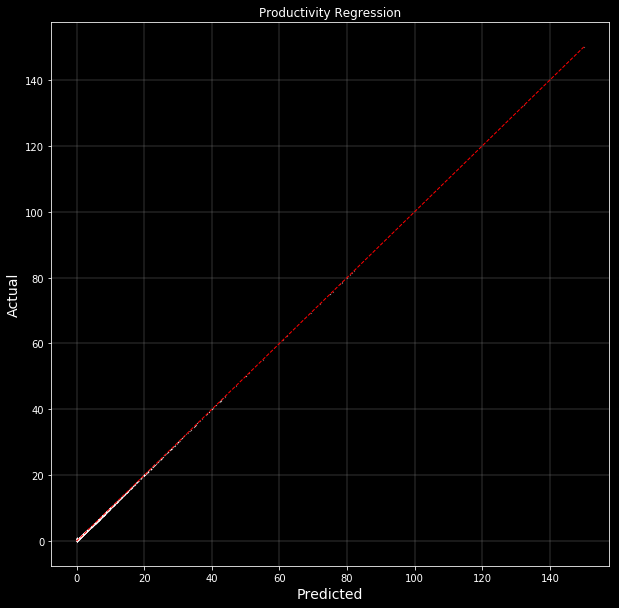

In [326]:
predictions=(test['product']/test['harvested area']).fillna(0)
predictions[predictions>250]=0
actuals=test['productivity'].fillna(0)
plt.figure(figsize=(10,10))
plt.plot(predictions,actuals,'w.',ms=.3)
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'r--', lw=1)
plt.xlabel("Predicted",fontsize=14)
plt.ylabel("Actual",fontsize=14)
plt.title("Productivity Regression")
plt.grid(c='gray',lw=.4)

In [327]:
import scipy.stats
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(predictions, actuals)

In [328]:
r_value

0.99993569552002548

In [1]:
200*5/60

16.666666666666668

In [7]:
import pandas as pd
dat=pd.read_csv('cFunDat.csv')
dat.head()

,List,List.1,List.2,1
0,0.133333,0.133333,0.133333,1
1,0.858824,0.262745,0.145098,1
2,0.858824,0.266667,0.145098,1
3,0.858824,0.266667,0.145098,1
4,0.858824,0.262745,0.145098,1


In [24]:
import pandas as pd
dat=pd.read_csv('cFunDat.csv')
import numpy as np
arr=np.array(dat)
def cust_cm(x):
    ind=round((x*1000))
    if ind>=1000:
        ind=999
    return arr[ind]

In [27]:
cust_cm(1)

array([ 0.05098039,  0.4       ,  0.40784314,  1.        ])